# Movie Database Part 7

*Christina Brockway*

**Part 1:  Preparing Best Models for Streamlit**
1.  Filepaths
    -  Define filepaths dictionary
    -  Save to config/filepaths.json
    -  include file paths for each component to save
2.  Copy best models
    - choose models from part 6
    - copy in to nb
    - update code to define public-facing class labels
3.  For Machine Learning
    -  save training data
    -  save testing data
    -  save target_lookup dictionary and/or label encoder
    -  save best model
4.  For Deep NLP model
    -  save training data
    -  save testing data
    -  save best neural network
    -  use safe_format='tf'

**Part 2: Streamlit App**
Create a Streamlit app to get model predictions for user entered-text
1.  Select model to use (ML or deep NLP)
2.  get predictions
3.  user-entered text
4.  include LimeTextExplainer explanation for prediction
5.  include abiblity to load evalution

In [1]:
## Define a file path

from pprint import pprint
FPATHS = dict(
        data={
        "filtered":  "data/movie-reviews-filtered.csv",
        "processed": "data/movie-reviews-tokenized.joblib",
        "ml": {
            "train": "data/training-data.joblib",  
            "test": "data/testing-data.joblib",
            
            "label_encoder":"data/label-encoder.joblib",
            'target_lookup':"data/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "data/training_tf",  
            "test_tf": "data/testing_tf", 
         },           
    },
    models={
        "rf": "models/rf-pipe.joblib", 
        "gscv": "models/best_model.joblib", 
        "gru": "models/tf/"
    },
    eda = {
        "scattertext": "eda/scattertext.html",
        "wordclouds-raw": "eda/wordclouds-raw-text.png",
        'wordclouds-lemmas':"eda/wordclouds-lemmas.png",
    }
)
pprint(FPATHS)

{'data': {'filtered': 'data/movie-reviews-filtered.csv',
          'ml': {'label_encoder': 'data/label-encoder.joblib',
                 'target_lookup': 'data/target-lookup-dict.joblib',
                 'test': 'data/testing-data.joblib',
                 'train': 'data/training-data.joblib'},
          'processed': 'data/movie-reviews-tokenized.joblib',
          'tf': {'test_tf': 'data/testing_tf', 'train_tf': 'data/training_tf'}},
 'eda': {'scattertext': 'eda/scattertext.html',
         'wordclouds-lemmas': 'eda/wordclouds-lemmas.png',
         'wordclouds-raw': 'eda/wordclouds-raw-text.png'},
 'models': {'gru': 'models/tf/',
            'gscv': 'models/best_model.joblib',
            'rf': 'models/rf-pipe.joblib'}}


In [2]:
#Save  filepaths in a config folder

import os, json
os.makedirs('config/', exist_ok = True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

In [66]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)


In [4]:
import os, sys
%load_ext autoreload
%autoreload 2
import stdfunctions as sf

In [5]:
# Check sys.path for python path
sys.path
#Get the absolute file path of parent directory
os.path.abspath('../')
#Add parent directory to python path
sys.path.append( os.path.abspath('../'))

In [6]:
# Using function from Creating a File Structure Lesson
sf.create_directories_from_paths(FPATHS)

In [7]:
processed = joblib.load("data/processed_data.joblib")

In [8]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 1 to 8647
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review         2422 non-null   object 
 1   rating         2422 non-null   float64
 2   html           160 non-null    object 
 3   length         2422 non-null   int64  
 4   tokens         2422 non-null   object 
 5   lemmas         2422 non-null   object 
 6   tokens-joined  2422 non-null   object 
 7   lemmas-joined  2422 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 170.3+ KB


In [9]:
len(processed)

2422

In [11]:
#drop reviews without a rating and irrelevent columns
#There are no rows without ratings
processed=processed.drop(columns=(['html', 'length','tokens','lemmas','tokens-joined','lemmas-joined']))
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 1 to 8647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  2422 non-null   object 
 1   rating  2422 non-null   float64
dtypes: float64(1), object(1)
memory usage: 56.8+ KB


In [18]:
#Split into high and low reviews
df = processed.copy()
def rating_groups(x):
    if x>=8.5:
        return "high"
    elif x <=4.0:
        return "low"
    else: 
        return None

In [19]:
df['label'] = processed['rating'].map(rating_groups)

# Map numeric value with public-facing label
rename_target_map ={'low': 'Low Rating', 'high':'High Rating'}

# Replace y values
y = df['rating'].replace(rename_target_map)
# Define X as normal
X = df['review']

df['label'].value_counts()

low     1223
high    1199
Name: label, dtype: int64

In [20]:
df.head(2)

,review,rating,label
1,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima...",9.0,high
6,"the first underwhelmed me, but this one straight-up bored me. again, of course seeing hunt climb a mountain without a harness is impressive sure. and i even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,low


In [21]:
df=df.drop(columns=('rating'))

In [30]:
#Train Test Split
X_train, X_test, y_train_str, y_test_str=train_test_split(X, y, random_state=42)
y_train.value_counts(normalize=True)

high    0.503855
low     0.496145
Name: label, dtype: float64

In [31]:
### Encoding Labels
## 1.  obtain class names

# Getting unique classes to convert 
class_names = y_train_str.unique()
class_names


array(['low', 'high'], dtype=object)

In [32]:
## 2. instantiate and fit LabelEncoder

from sklearn.preprocessing import LabelEncoder
# Fit the label encoder on unique class names
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [33]:
### 3.  Transform string values with encoder

# Transform the y_train_str and y_test_str with encoder
y_train = encoder.transform(y_train_str)
y_test = encoder.transform(y_test_str)
y_train[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

In [34]:
#### 4.  Extract class names from the encoder object

# Extract the class names from the encoder
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [35]:
##### 5. Transform these to obtain the encoded values

# Get the encoded values for each both classes
class_codes = encoder.transform(classes)
class_codes

array([0, 1])

In [36]:
###### 6. Make lookup dictionary that will match the ncoded value with the string name

# Making lookup dictionary to find the encoded label's original name
target_lookup = dict(zip(class_codes,classes ))
target_lookup

{0: 'high', 1: 'low'}

In [37]:
### Class Balance

# Check for class balance
pd.Series(y_train).value_counts(normalize=True)

0    0.503855
1    0.496145
dtype: float64

In [38]:
# Use RUS to balance the classes
sampler = RandomUnderSampler(random_state=42)
X_train, y_train = sampler.fit_resample(X_train.values.reshape(-1,1),y_train)
X_train = X_train.flatten()

# Check for class balance
pd.Series(y_train).value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

In [39]:
#Save filtered dataframe
fpath = FPATHS['data']['filtered']
df.to_csv(fpath)

#Saving the training data
fpath_train  = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)

# Saving the testing data
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)

#Save encoder
fpath_encoder = FPATHS['data']['ml']['label_encoder']
joblib.dump(encoder,fpath_encoder)

# Save dictionary
fpath_lookup = FPATHS['data']['ml']['target_lookup']
joblib.dump(target_lookup,fpath_lookup )

['data/target-lookup-dict.joblib']

### Machine Learning Model

In [40]:
#Create pipeline

# Select a sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words ='english')

#Use RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

rfc_pipe = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', rfc)])


In [41]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       901
           1       1.00      1.00      1.00       901

    accuracy                           1.00      1802
   macro avg       1.00      1.00      1.00      1802
weighted avg       1.00      1.00      1.00      1802



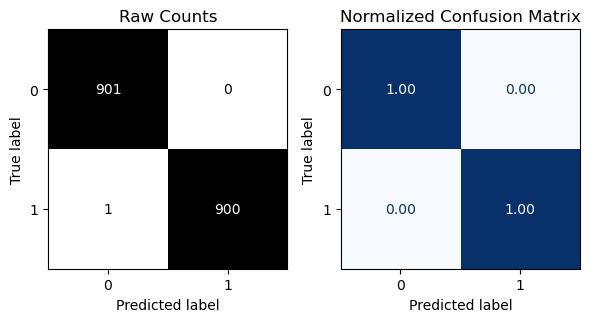


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       284
           1       0.86      0.83      0.85       322

    accuracy                           0.84       606
   macro avg       0.84      0.84      0.84       606
weighted avg       0.84      0.84      0.84       606



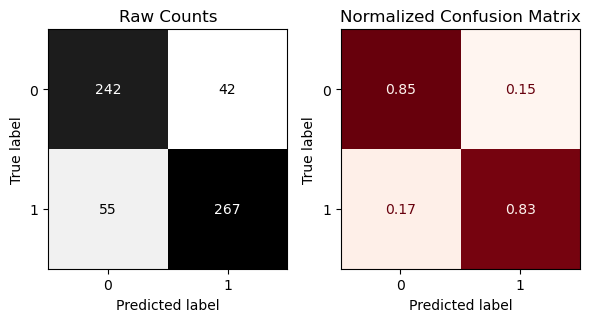

In [42]:
sf.evaluate_classification(rfc_pipe, X_train, y_train, X_test, y_test)

In [44]:
#Save random forest model pipeline

fpath_rf_pipe = FPATHS['models']['rf']
joblib.dump(rfc_pipe, fpath_rf_pipe)

['models/rf-pipe.joblib']

#### Deep NLP

In [45]:
# load training data using dictionary
[X_train, y_train] = joblib.load(FPATHS['data']['ml']['train'])
[X_test, y_test]  = joblib.load(FPATHS['data']['ml']['test'])
X_train[:5],y_train[:5]

(array(['**zack snyder creates an entire dc universe in one film filled with gritty new takes on familiar characters and brutal action.**\r\n\r\ni know this is a polarizing thing to say, but i loved this movie! i think zack snyder crushed it with the incredible production design, off-the-charts casting, and gritty take on a lost and weary batman. the casting for this movie is a master stroke of brilliance. ben affleck’s batman is jaded and bitter, taking his rage and loss out on the criminal element of gotham. his hulking physique emphasizes batman’s imposing strength over his gadgets when in combat. zack snyder also gave us gal gadot as wonder woman, which we all know is one of the best choices in the comic book cinema world. the fight sequences are the best part of bvs; pitting godlike power against a man motivated by grief somehow seems possible and brutal because of snyder’s writing and directing. finally, the world-building and teases bring so much intrigue and excitement for futu

### Prepare Dataset for TensorFlow

In [46]:
# Make a dataset object from train data
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Make a dataset object from test data
test_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [47]:
# Shuffle dataset
train_tf = train_tf.shuffle(buffer_size=len(train_tf),reshuffle_each_iteration=False)

In [48]:
len(train_tf), len(test_tf)

(1802, 606)

In [49]:
# Set the ratio of the train, validation, test split
split_train = .75
split_val =  .25
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(train_tf) * split_train)
n_val_samples = int(len(train_tf) * split_val)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")


    - train:	1351 samples 	(43 batches)
    - val:  	450 samples 	(15 batches)


In [50]:
# Use take and skip to define each set
train_ds = train_tf.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = train_tf.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')

 There are 43 training batches.
 There are 15 validation batches.


In [51]:
# How many samples in the test data
n_test_samples = len(test_tf)
n_test_samples

606

In [52]:
# Put the test data into batches also
test_ds = test_tf.batch(batch_size = BATCH_SIZE)
# How many batches
print (f' There are {len(test_ds)} testing batches.')

 There are 19 testing batches.


In [53]:
# Save training dataset object
train_ds_fpath = FPATHS['data']['tf']['train_tf']
tf.data.Dataset.save(train_ds, train_ds_fpath)
# Save testing dataset object
test_ds_fpath = FPATHS['data']['tf']['test_tf']
tf.data.Dataset.save(test_ds, test_ds_fpath)

In [54]:
##Obtain a single batch from training data to sample

# Define classes
# classes = np.unique(example_y)
encoder = joblib.load(FPATHS['data']['ml']['label_encoder'])
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [60]:
# Create Text Vectorization Layer
sequence_vectorizer, vocab_lookup = sf.make_text_vectorization_layer(
    train_ds, output_mode="int", output_sequence_length=30, verbose=True
)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 30,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 21362}
)


In [61]:
sequence_vectorizer.vocabulary_size()

21362

In [63]:
from keras import regularizers

def build_gru_bidirectional_pool(text_vectorization_layer):
    
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()                
    
    rnn_model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                        output_dim=EMBED_DIM,  input_length=SEQUENCE_LENGTH)])
   
# Stack three GrU layers    
    rnn_model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, 
                                  kernel_regularizer=regularizers.l2(0.0001))))
    rnn_model.add(layers.Dropout(0.3))
    rnn_model.add(layers.GRU(64, return_sequences=True,
                             kernel_regularizer=regularizers.l1(0.0001)))
    rnn_model.add(layers.Dropout(0.2))
    rnn_model.add(layers.GRU(32, return_sequences=True,
                             kernel_regularizer=regularizers.l2(0.0001)))
          
    rnn_model.add(layers.Bidirectional(layers.GRU(32, return_sequences = True,)))
                  
    # Add a pooling layer 
    rnn_model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    rnn_model.add(layers.Dense(len(classes), 
                                    activation='sigmoid'))
                     
    optimizer = optimizers.legacy.Adam()
    rnn_model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn_model.summary()
    return rnn_model

In [64]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy', min_delta=1e-2,):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [68]:
# Build the model
EMBED_DIM = 100
SEQUENCE_LENGTH = 150
model = build_gru_bidirectional_pool(sequence_vectorizer)

#Fit the model
EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 30, 100)           2136200   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          176640    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            61824     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0

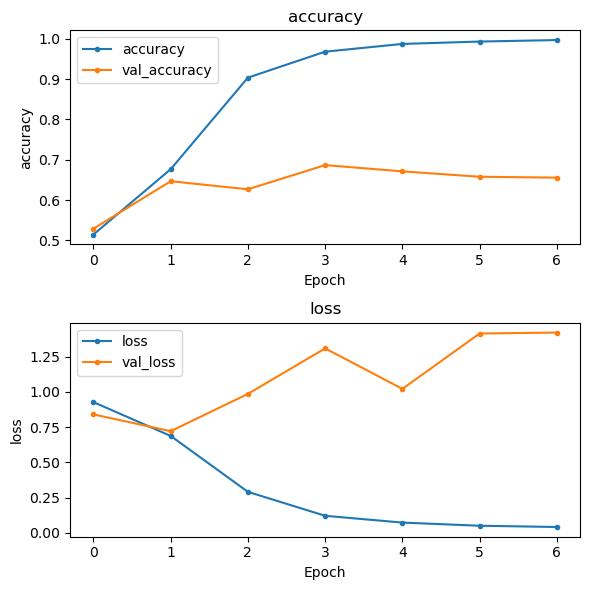


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       679
           1       0.99      1.00      0.99       672

    accuracy                           0.99      1351
   macro avg       0.99      0.99      0.99      1351
weighted avg       0.99      0.99      0.99      1351



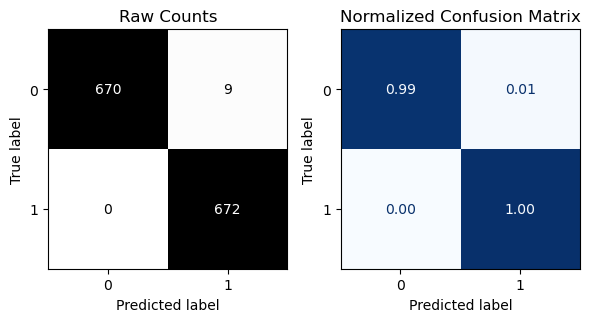


- Evaluating Training Data:
43/43 [==============================] - 1s 21ms/step - loss: 0.0385 - accuracy: 0.9933
{'loss': 0.038532573729753494, 'accuracy': 0.9933382868766785}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       284
           1       0.68      0.72      0.70       322

    accuracy                           0.67       606
   macro avg       0.67      0.67      0.67       606
weighted avg       0.67      0.67      0.67       606



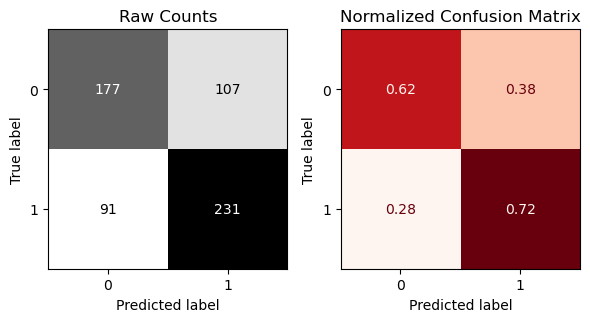


- Evaluating Test Data:
19/19 [==============================] - 0s 19ms/step - loss: 1.2541 - accuracy: 0.6733
{'loss': 1.2540549039840698, 'accuracy': 0.6732673048973083}


In [69]:
# Obtain the results
results = sf.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);
results

In [ ]:
### Save deep NLP model 

fpath_rf_pipe = FPATHS['models']['rf']
joblib.dump(rf_pipe, fpath_rf_pipe)